In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd

In [6]:
# Load log returns
df = pd.read_csv('../../data/interim/brent_oil_log_returns.csv')
log_returns = df['Log_Returns'].dropna().values
dates_lr = df['Date'].iloc[1:]  # first row dropped due to diff()

n = len(log_returns)



In [7]:
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)

    mu_1 = pm.Normal('mu_1', mu=0, sigma=0.02)
    mu_2 = pm.Normal('mu_2', mu=0, sigma=0.02)

    sigma_1 = pm.HalfNormal('sigma_1', sigma=0.01)
    sigma_2 = pm.HalfNormal('sigma_2', sigma=0.01)

    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)
    sigma = pm.math.switch(tau >= np.arange(n), sigma_1, sigma_2)

    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


/home/teshager/Documents/projects/10Academy/brent-oil-changepoint-analysis/venv/lib/python3.12/site-packages/rich/l
ive.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5386.635,21.502,5345.000,5421.000,0.69,0.456,1038.0,1414.0,1.0
mu_1,0.000,0.000,-0.000,0.001,0.00,0.000,10915.0,5458.0,1.0
mu_2,-0.000,0.000,-0.001,0.001,0.00,0.000,9649.0,5724.0,1.0
sigma_1,0.023,0.000,0.023,0.023,0.00,0.000,11724.0,6412.0,1.0
sigma_2,0.029,0.000,0.028,0.030,0.00,0.000,8357.0,5660.0,1.0


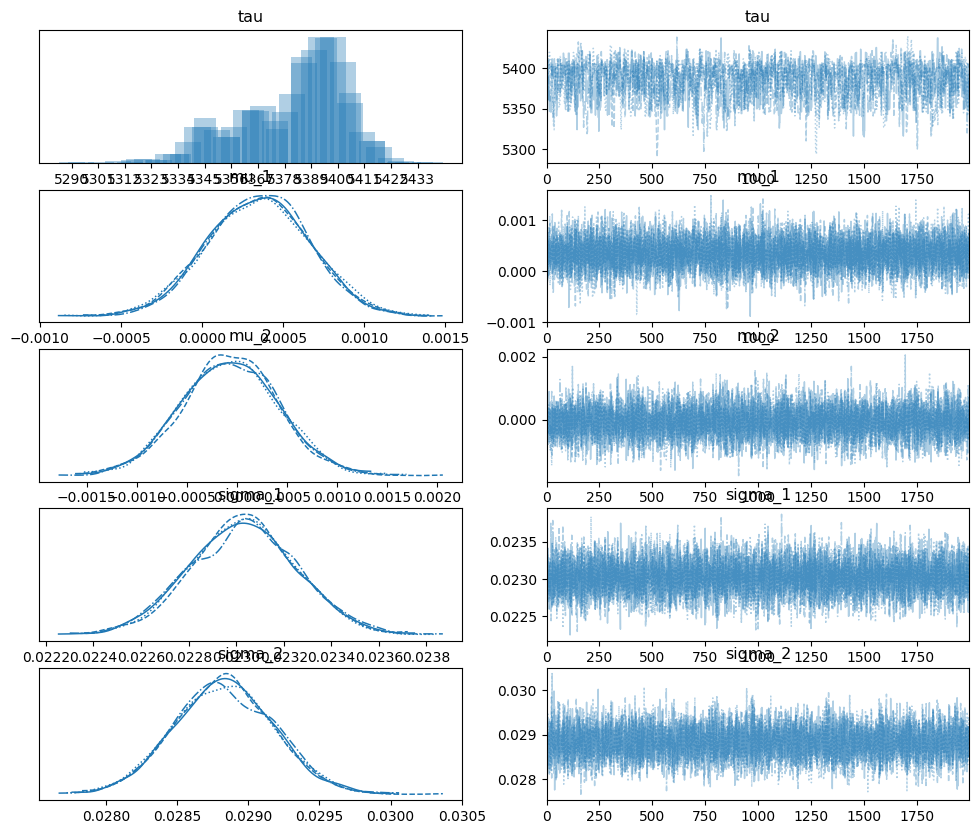

In [ ]:


az.plot_trace(trace)
az.summary(trace, hdi_prob=0.95)

In [12]:
tau_samples = trace.posterior['tau'].values.flatten()

In [14]:
tau_most_probable = int(np.round(tau_samples.mean()))
changepoint_date = df.index[tau_most_probable]
print("Most probable changepoint date:", changepoint_date)

Most probable changepoint date: 5387


In [9]:
# Save trace
trace.to_netcdf("../../data/bcp_trace.nc")

'../../data/bcp_trace.nc'